In [1]:
%run C:\Users\HSS\dd.py

In [2]:
import os
cwd = os.getcwd()


In [3]:
cwd

'C:\\Users\\HSS\\Documents\\dev\\Lets-EDA'

In [4]:
import time
start = time.time()
train = pd.read_csv(cwd+'/data/train.csv')
end = time.time()
print(end-start)

180.7127287387848


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [6]:
data = train.copy()

In [7]:
data.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


- `groupId` - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- `matchId` - Integer ID to identify match. There are no matches that are in both the training and testing set.
- `assists` - Number of enemy players this player damaged that were killed by teammates.
- `boosts` - Number of boost items used.
- `damageDealt` - Total damage dealt. Note: Self inflicted damage is subtracted.
- `DBNOs` - Number of enemy players knocked.
- `headshotKills` - Number of enemy players killed with headshots.
- `heals` - Number of healing items used.
- `killPlace` - Ranking in match of number of enemy players killed.
- `killPoints` - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- `kills` - Number of enemy players killed.
- `killStreaks` - Max number of enemy players killed in a short amount of time.
- `longestKill` - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- `maxPlace` - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- `numGroups` - Number of groups we have data for in the match.
- `revives` - Number of times this player revived teammates.
- `rideDistance` - Total distance traveled in vehicles measured in meters.
- `roadKills` - Number of kills while in a vehicle.
- `swimDistance` - Total distance traveled by swimming measured in meters.
- `teamKills` - Number of times this player killed a teammate.
- `vehicleDestroys` - Number of vehicles destroyed.
- `walkDistance` - Total distance traveled on foot measured in meters.
- `weaponsAcquired` - Number of weapons picked up.
- `winPoints` - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- `winPlacePerc` - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

## 1. The killers

- 일단 `print`도 굉장히 많이 사용되고, `.format`의 활용법을 알아놔야할 듯

In [8]:
print('플레이어들은 평균 {:.4f} 킬을 기록했고, 99%의 플레이들은 {} 킬 이하를, 가장 킬을 많이한 여포는 무려 {}명의 뚝배기를 부쉈다...'
     .format(data['kills'].mean(), data['kills'].quantile(0.99), data['kills'].max()))

플레이어들은 평균 0.9248 킬을 기록했고, 99%의 플레이들은 7.0 킬 이하를, 가장 킬을 많이한 여포는 무려 72명의 뚝배기를 부쉈다...


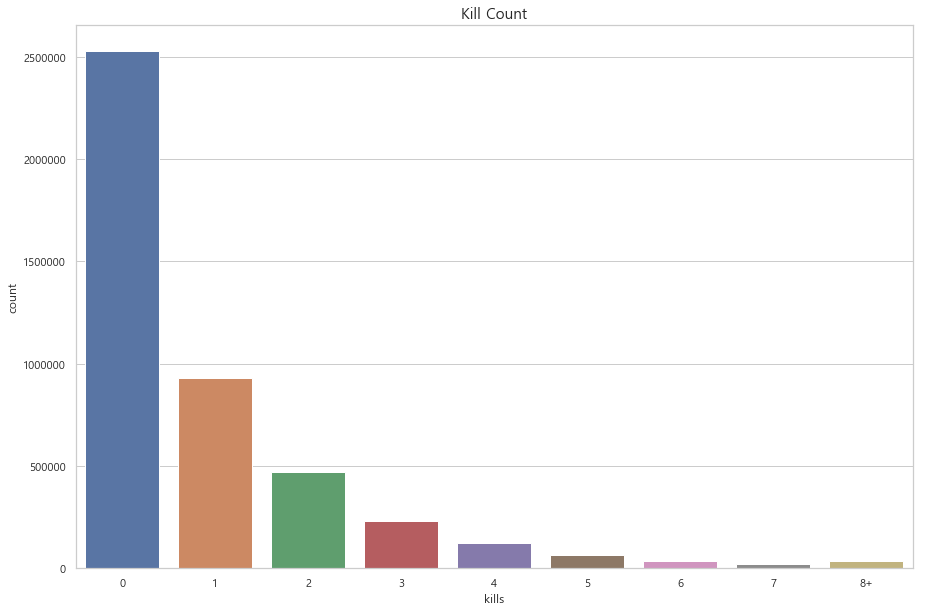

In [9]:
#sns.countplot 사용법 익히기 : 일단 히스토그램과 비슷함
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

- 약 58%는 1킬도 못하고 사망한다.

In [10]:
round(len(data['kills'][data['kills']==0])/len(data['kills'])*100,2)

56.89

- 이 58%의 사람들은 누구를 맞추기는 하는걸까?
- `data['kills']`의 일부를 '8+'라는 str로 변경했다. 다시 data를 원 train에서 deep copy한다.
- 이 사람은 한 작업이 끝나면 계속해서 data를 원복하는 과정을 반복했다. 
- 하나의 분석 과정이 불필요하게 다음 분석에 영향을 미치는 것을 꺼리는 듯 하다.

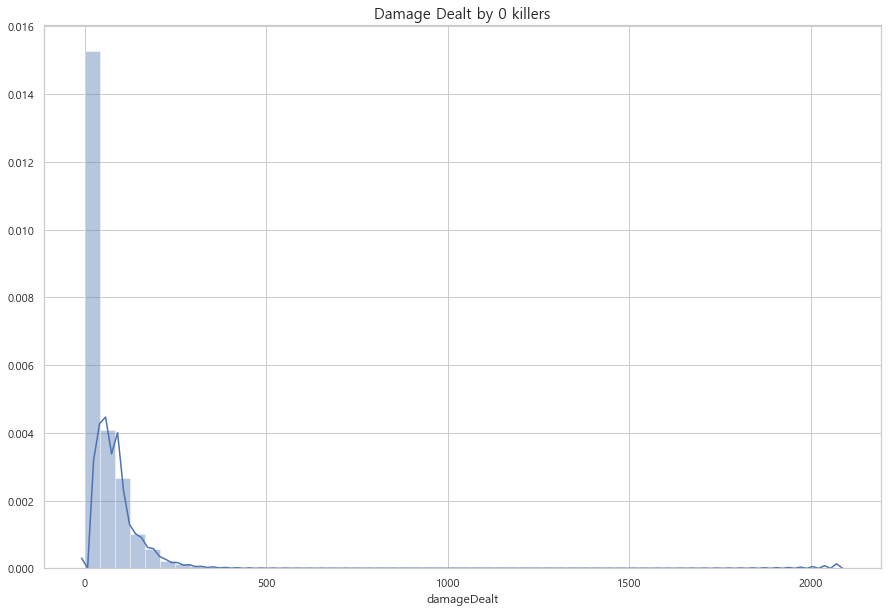

In [11]:
data = train.copy()
zeros = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(zeros['damageDealt'])
plt.show()

- 아.. 계속 copy하니까 시간이 생각보다 오래 걸리는데? 좋은 컴퓨터에서 하거나 AWS에서 다시 해보고 앞으로 어떻게 할지는 고민해봐야겠다.

In [12]:
zero_len = len(zeros['damageDealt'][zeros['damageDealt']==0])
zero_pct = round(zero_len/len(zeros['damageDealt'])*100)


In [13]:
zero_len, zero_pct

(1233949, 49)

In [14]:
print('전체 {}명 중 \n 0킬인 플레이어 {}명\n  이의 {}%인 {}명은 한발도 맞추지 못하고 전장에서 쓰러졌다...'
      .format(len(data),len(zeros), zero_pct, zero_len))

전체 4446966명 중 
 0킬인 플레이어 2529722명
  이의 49%인 1233949명은 한발도 맞추지 못하고 전장에서 쓰러졌다...


#### - 반대로 하나의 킬도 기록하지 못하고 이긴 사람, 한발도 못 맞추고 이긴 사람은 전체의 몇%, 몇명일까?

In [23]:
#우승자의 수
len(data[data['winPlacePerc']==1])

127573

In [24]:
#1킬도 하지 못한 사람(zeros) 중 우승자
len(zeros[zeros['winPlacePerc']==1])


16666

In [26]:
#아예 딜 자체가 0인 사람 
gandis = zeros[zeros['damageDealt']==0]
len(gandis)
#간디 중 아예 우승까지 도달한 대단한 녀석들
len(gandis[gandis['winPlacePerc']==1])

4709

In [28]:
print('우승자 중 {}명의 플레이어들 ({}%) 은 1킬도 없이 우승했다..  그리고 {}명의 플레이어(간디의 환생 {}%)는 한대도 맞추지 않고 우승했다.'
     .format(len(zeros[zeros['winPlacePerc']==1]), 
             round(len(zeros[zeros['winPlacePerc']==1]) / len(data[data['winPlacePerc']==1])*100),
            len(gandis[gandis['winPlacePerc']==1]), 
             round(len(gandis[gandis['winPlacePerc']==1])/len(data[data['winPlacePerc']==1])*100) ))

우승자 중 16666명의 플레이어들 (13%) 은 1킬도 없이 우승했다..  그리고 4709명의 플레이어(간디의 환생 4%)는 한대도 맞추지 않고 우승했다.


#### 킬 (전투능력)과 승리의 상관성 sns.jointplot
- 확실히 전투능력과 승리는 상관성을 갖는다.(어느정도 예상이 가능한 상관성) 그렇지만 흔히 하는 실수로 이를 인과관계로 여기진 말자.
- 오래 살아남는 사람은 자연스레 다른 사람을 죽일 기회(time)이 많아지기 때문에 나타난 상관성으로 볼 수도 있다.
- 인과관계에서는 최대한 보수적으로

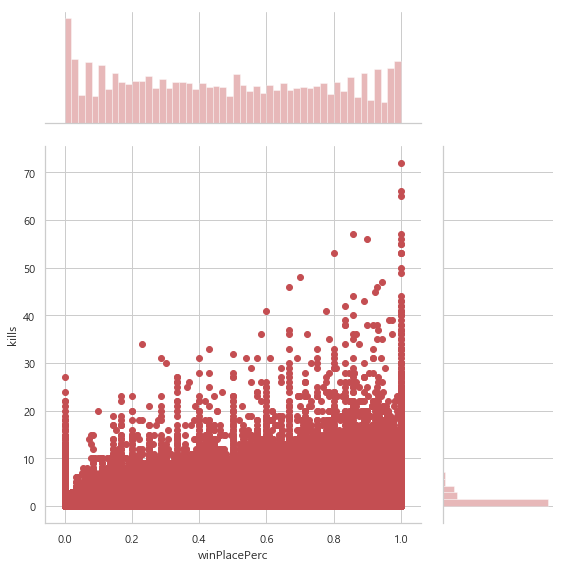

In [34]:
sns.jointplot(x = 'winPlacePerc', y = 'kills', data = data, height=8, ratio=3, color="r")
plt.show()

#### 킬과 승리 boxplot


In [35]:
# 새로운 카테고리를 만들기 때문에 copy하자
kills = train.copy()

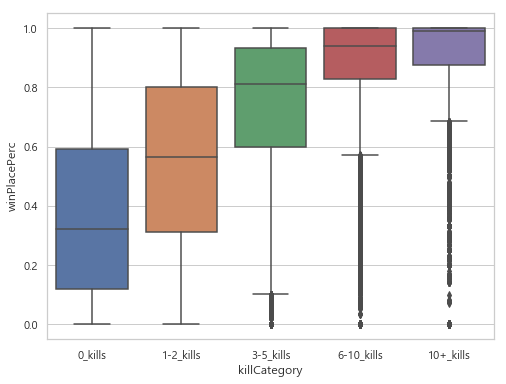

In [37]:
#0, 1-2, 3-5, 6-10, 10+ 여포(max)=72
kills['killCategory'] = pd.cut(kills['kills'], [-1,0,2,5,10,72], 
                               labels = ['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])
plt.figure(figsize = (8,6))
sns.boxplot(x = 'killCategory', y = 'winPlacePerc', data = kills)
plt.show()

## 2. The runners


In [42]:
#평균 이동 거리, 하위 99%, 최상위1명 (이봉주) 
print('플레이어들은 평균 {}m 를 이동했고 99%는 {}m 이하를, 가장 많이 이동한 우리의 이봉주! 그는 무려 {}m 를 이동했다. '
     .format(
     round(train['walkDistance'].mean(),1),
     train['walkDistance'].quantile(0.99),
     train['walkDistance'].max()))


플레이어들은 평균 1154.2m 를 이동했고 99%는 4396.0m 이하를, 가장 많이 이동한 우리의 이봉주! 그는 무려 25780.0m 를 이동했다. 


In [45]:
#갑자기 든 궁금증. 우리의 이봉주의 성적은 상위 몇 %였을~~까?

print(train[train['walkDistance'] == train['walkDistance'].max()]['winPlacePerc']*100)

# 뛴 보람이 있었네..

497965    98.94
Name: winPlacePerc, dtype: float64


#### 99% 유저의 이동 거리의 distribution

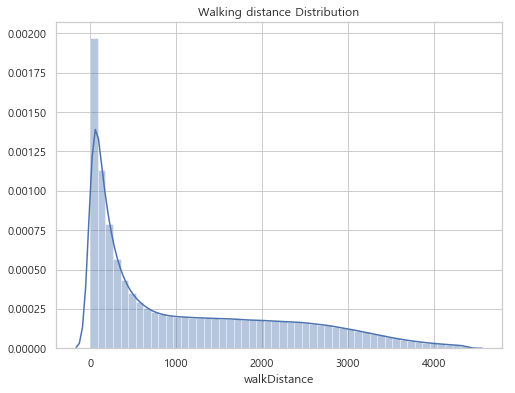

In [46]:
# 일단 99%의 유저를 추려내자.
data = train.copy()
data = data[data['walkDistance'] <= data['walkDistance'].quantile(0.99)]

#그래프 distplot
plt.figure(figsize = (8,6))
plt.title('Walking distance Distribution')
sns.distplot(data['walkDistance'])
plt.show()

#y축이 쬐까..뭐지..?

In [48]:
# 아예 움직이지 않은 사람들
len_0_walk = len(data[data['walkDistance']==0])
# 퍼센트
pct_0_walk = round(100*len_0_walk/len(train))

print('아예 움직이지 않은 사람들은 {}%다. 이 {}명의 플레이어들은 착지하자 마자 즉사했거나, 딴짓하느라 혹은 튕겨서 afk된 유저들일 가능성이 높다.'
     .format(pct_0_walk, len_0_walk))

아예 움직이지 않은 사람들은 2%다. 이 99603명의 플레이어들은 착지하자 마자 즉사했거나, 딴짓하느라 혹은 튕겨서 afk된 유저들일 가능성이 높다.


#### 우리의 관심사인 winPlacePerc과 walkDistance jointplot

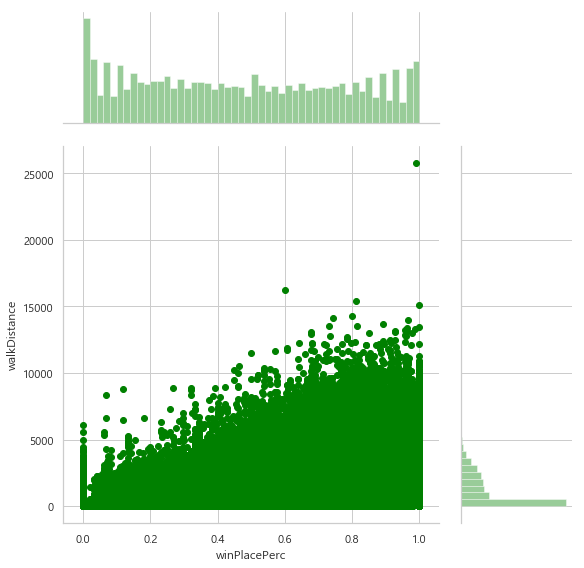

In [56]:
sns.jointplot(x = 'winPlacePerc', y = 'walkDistance', data = train, height = 8, ratio = 3, color = 'green')
plt.show()

## 3. The drivers

In [6]:
data = train.copy()

In [11]:
print('플레이어들은 평균 {}m를 운전했고 99%가 {}m 이하를 운전했다. 그리고 가장 많은 거리를 운전한 우리의 베스트 드라이버는 {}m 를 운전했다.'
     .format(round(data['rideDistance'].mean(),2), data['rideDistance'].quantile(0.99), data['rideDistance'].max()))

플레이어들은 평균 606.12m를 운전했고 99%가 6966.0m 이하를 운전했다. 그리고 가장 많은 거리를 운전한 우리의 베스트 드라이버는 40710.0m 를 운전했다.


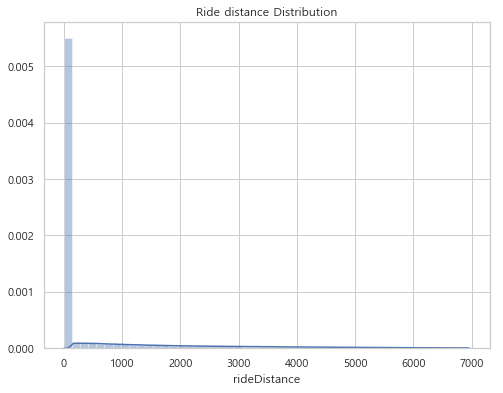

In [12]:
data = data[data['rideDistance'] <= data['rideDistance'].quantile(0.99)]
plt.figure(figsize = (8,6))
plt.title('Ride distance Distribution')
sns.distplot(data['rideDistance'])
plt.show()


In [17]:
len(data[data['rideDistance']==0])

3309429